**Synchronizing google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing all the ingredients for our script.
If you have errors such as: no module named 'example'

try: **pip install example**

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.utils import save_image
from IPython.display import Image 
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
batch_size = 100
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="drive/MyDrive/Dataset/landscapeResized",transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

15000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


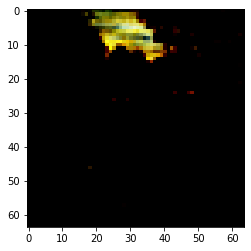

In [ ]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


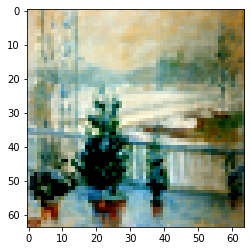

In [ ]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


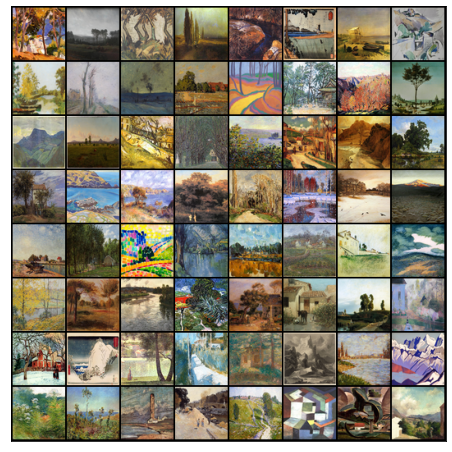

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 150

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

# Defining the Model

torch.Size([128, 3, 64, 64])


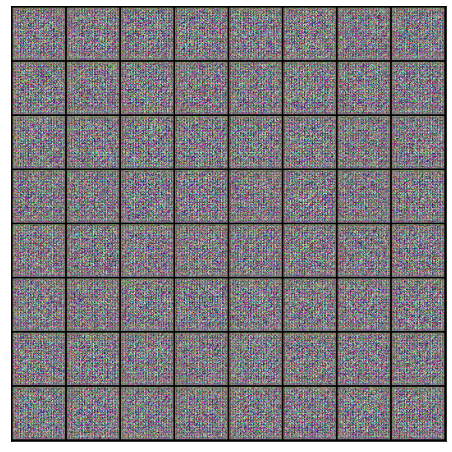

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'drive/MyDrive/generatedLandscape'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


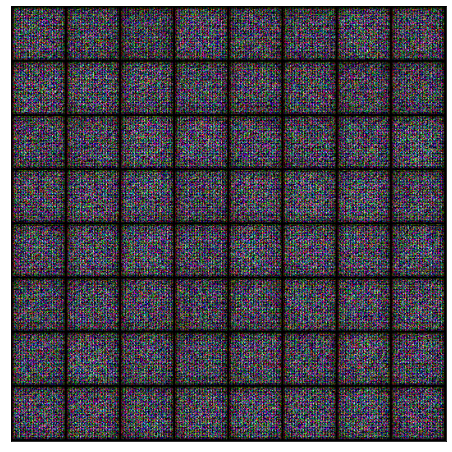

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.001
epochs = 150

In [ ]:
history = fit(epochs,lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/150], loss_g: 1.3248, loss_d: 1.2115, real_score: 0.4958, fake_score: 0.3316
Saving generated-images-0001.png



Epoch [2/150], loss_g: 2.9415, loss_d: 1.3596, real_score: 0.6188, fake_score: 0.5180
Saving generated-images-0002.png



Epoch [3/150], loss_g: 2.0526, loss_d: 1.2778, real_score: 0.5546, fake_score: 0.3445
Saving generated-images-0003.png



Epoch [4/150], loss_g: 2.4739, loss_d: 0.6299, real_score: 0.7073, fake_score: 0.2030
Saving generated-images-0004.png



Epoch [5/150], loss_g: 2.3368, loss_d: 0.7985, real_score: 0.6756, fake_score: 0.3034
Saving generated-images-0005.png



Epoch [6/150], loss_g: 1.9901, loss_d: 0.7927, real_score: 0.7707, fake_score: 0.3499
Saving generated-images-0006.png



Epoch [7/150], loss_g: 2.3111, loss_d: 0.6460, real_score: 0.6381, fake_score: 0.1367
Saving generated-images-0007.png



Epoch [8/150], loss_g: 2.3141, loss_d: 1.1091, real_score: 0.4887, fake_score: 0.1320
Saving generated-images-0008.png



Epoch [9/150], loss_g: 3.2894, loss_d: 0.6608, real_score: 0.8299, fake_score: 0.3490
Saving generated-images-0009.png



Epoch [10/150], loss_g: 3.9920, loss_d: 1.2187, real_score: 0.8378, fake_score: 0.5818
Saving generated-images-0010.png



Epoch [11/150], loss_g: 0.9520, loss_d: 1.4814, real_score: 0.3458, fake_score: 0.1519
Saving generated-images-0011.png



Epoch [12/150], loss_g: 3.5665, loss_d: 0.7186, real_score: 0.5804, fake_score: 0.0632
Saving generated-images-0012.png



Epoch [13/150], loss_g: 5.7422, loss_d: 0.8228, real_score: 0.8345, fake_score: 0.4283
Saving generated-images-0013.png



Epoch [14/150], loss_g: 4.9743, loss_d: 0.5428, real_score: 0.8599, fake_score: 0.2848
Saving generated-images-0014.png



Epoch [15/150], loss_g: 5.1527, loss_d: 0.5799, real_score: 0.8485, fake_score: 0.2858
Saving generated-images-0015.png



Epoch [16/150], loss_g: 0.7415, loss_d: 1.2695, real_score: 0.5096, fake_score: 0.3124
Saving generated-images-0016.png



Epoch [17/150], loss_g: 6.4976, loss_d: 0.6557, real_score: 0.9256, fake_score: 0.3943
Saving generated-images-0017.png



Epoch [18/150], loss_g: 7.9323, loss_d: 1.3993, real_score: 0.9318, fake_score: 0.6851
Saving generated-images-0018.png



Epoch [19/150], loss_g: 5.4012, loss_d: 0.8598, real_score: 0.9171, fake_score: 0.4645
Saving generated-images-0019.png



Epoch [20/150], loss_g: 2.3689, loss_d: 0.7092, real_score: 0.6744, fake_score: 0.1472
Saving generated-images-0020.png



Epoch [21/150], loss_g: 3.5486, loss_d: 0.7739, real_score: 0.8340, fake_score: 0.3802
Saving generated-images-0021.png



Epoch [22/150], loss_g: 1.9761, loss_d: 1.4973, real_score: 0.3023, fake_score: 0.0310
Saving generated-images-0022.png



Epoch [23/150], loss_g: 1.9194, loss_d: 1.1340, real_score: 0.5087, fake_score: 0.2171
Saving generated-images-0023.png



Epoch [24/150], loss_g: 3.2296, loss_d: 0.5429, real_score: 0.8395, fake_score: 0.2156
Saving generated-images-0024.png



Epoch [25/150], loss_g: 2.6808, loss_d: 0.6891, real_score: 0.5932, fake_score: 0.0787
Saving generated-images-0025.png



Epoch [26/150], loss_g: 2.6384, loss_d: 0.5852, real_score: 0.7346, fake_score: 0.1857
Saving generated-images-0026.png



Epoch [27/150], loss_g: 4.1623, loss_d: 0.9324, real_score: 0.8798, fake_score: 0.4849
Saving generated-images-0027.png



Epoch [28/150], loss_g: 2.5752, loss_d: 0.9856, real_score: 0.6267, fake_score: 0.3091
Saving generated-images-0028.png



Epoch [29/150], loss_g: 5.5012, loss_d: 1.6302, real_score: 0.9186, fake_score: 0.7053
Saving generated-images-0029.png



Epoch [30/150], loss_g: 2.7715, loss_d: 0.6631, real_score: 0.6646, fake_score: 0.1183
Saving generated-images-0030.png



Epoch [31/150], loss_g: 2.5407, loss_d: 0.8556, real_score: 0.5346, fake_score: 0.0828
Saving generated-images-0031.png



Epoch [32/150], loss_g: 2.3716, loss_d: 0.5678, real_score: 0.6494, fake_score: 0.0391
Saving generated-images-0032.png



Epoch [33/150], loss_g: 1.4676, loss_d: 1.2276, real_score: 0.4279, fake_score: 0.1284
Saving generated-images-0033.png



Epoch [34/150], loss_g: 1.6872, loss_d: 0.9920, real_score: 0.5689, fake_score: 0.2205
Saving generated-images-0034.png



Epoch [35/150], loss_g: 1.6693, loss_d: 0.7072, real_score: 0.6261, fake_score: 0.1404
Saving generated-images-0035.png



Epoch [36/150], loss_g: 3.2026, loss_d: 0.7159, real_score: 0.6804, fake_score: 0.1597
Saving generated-images-0036.png



Epoch [37/150], loss_g: 4.7652, loss_d: 1.1863, real_score: 0.7427, fake_score: 0.5051
Saving generated-images-0037.png



Epoch [38/150], loss_g: 3.5328, loss_d: 0.5750, real_score: 0.6409, fake_score: 0.0375
Saving generated-images-0038.png



Epoch [39/150], loss_g: 1.5102, loss_d: 1.0158, real_score: 0.4943, fake_score: 0.1004
Saving generated-images-0039.png



Epoch [40/150], loss_g: 4.9634, loss_d: 0.5725, real_score: 0.9359, fake_score: 0.3483
Saving generated-images-0040.png



Epoch [41/150], loss_g: 6.0993, loss_d: 1.6060, real_score: 0.9704, fake_score: 0.7210
Saving generated-images-0041.png



Epoch [42/150], loss_g: 2.8898, loss_d: 0.8441, real_score: 0.8126, fake_score: 0.4096
Saving generated-images-0042.png



Epoch [43/150], loss_g: 3.9174, loss_d: 0.4075, real_score: 0.7411, fake_score: 0.0391
Saving generated-images-0043.png



Epoch [44/150], loss_g: 4.0963, loss_d: 0.8231, real_score: 0.8154, fake_score: 0.3922
Saving generated-images-0044.png



Epoch [45/150], loss_g: 3.0989, loss_d: 0.6890, real_score: 0.7814, fake_score: 0.2936
Saving generated-images-0045.png



Epoch [46/150], loss_g: 1.2128, loss_d: 0.9567, real_score: 0.5769, fake_score: 0.2328
Saving generated-images-0046.png



Epoch [47/150], loss_g: 2.3961, loss_d: 1.0209, real_score: 0.4824, fake_score: 0.0490
Saving generated-images-0047.png



Epoch [48/150], loss_g: 4.6653, loss_d: 0.7854, real_score: 0.8294, fake_score: 0.3650
Saving generated-images-0048.png



Epoch [49/150], loss_g: 2.3890, loss_d: 0.3691, real_score: 0.8381, fake_score: 0.1394
Saving generated-images-0049.png



Epoch [50/150], loss_g: 1.8121, loss_d: 0.8380, real_score: 0.6874, fake_score: 0.2007
Saving generated-images-0050.png



Epoch [51/150], loss_g: 3.2849, loss_d: 0.4854, real_score: 0.8496, fake_score: 0.2267
Saving generated-images-0051.png



Epoch [52/150], loss_g: 3.1410, loss_d: 0.4263, real_score: 0.7016, fake_score: 0.0316
Saving generated-images-0052.png



Epoch [53/150], loss_g: 7.1265, loss_d: 1.4618, real_score: 0.9498, fake_score: 0.6685
Saving generated-images-0053.png



Epoch [54/150], loss_g: 4.0170, loss_d: 0.8991, real_score: 0.5192, fake_score: 0.0180
Saving generated-images-0054.png



Epoch [55/150], loss_g: 1.2634, loss_d: 0.7865, real_score: 0.6287, fake_score: 0.0861
Saving generated-images-0055.png



Epoch [56/150], loss_g: 4.9386, loss_d: 1.1757, real_score: 0.8834, fake_score: 0.5413
Saving generated-images-0056.png



Epoch [57/150], loss_g: 7.7554, loss_d: 0.9924, real_score: 0.9579, fake_score: 0.5246
Saving generated-images-0057.png



Epoch [58/150], loss_g: 2.4386, loss_d: 0.3697, real_score: 0.8328, fake_score: 0.1333
Saving generated-images-0058.png



Epoch [59/150], loss_g: 1.8975, loss_d: 0.7695, real_score: 0.6296, fake_score: 0.1671
Saving generated-images-0059.png



Epoch [60/150], loss_g: 1.7053, loss_d: 0.7621, real_score: 0.5622, fake_score: 0.0321
Saving generated-images-0060.png



Epoch [61/150], loss_g: 2.2839, loss_d: 0.8675, real_score: 0.6447, fake_score: 0.2423
Saving generated-images-0061.png



Epoch [62/150], loss_g: 3.2651, loss_d: 0.3683, real_score: 0.9459, fake_score: 0.2251
Saving generated-images-0062.png



Epoch [63/150], loss_g: 4.6558, loss_d: 0.1734, real_score: 0.9694, fake_score: 0.1186
Saving generated-images-0063.png



Epoch [64/150], loss_g: 3.7451, loss_d: 0.3553, real_score: 0.8933, fake_score: 0.1588
Saving generated-images-0064.png



Epoch [65/150], loss_g: 4.0110, loss_d: 0.1466, real_score: 0.9500, fake_score: 0.0826
Saving generated-images-0065.png



Epoch [66/150], loss_g: 1.3958, loss_d: 0.6939, real_score: 0.6583, fake_score: 0.0878
Saving generated-images-0066.png



Epoch [67/150], loss_g: 2.2738, loss_d: 0.5639, real_score: 0.8253, fake_score: 0.2358
Saving generated-images-0067.png



Epoch [68/150], loss_g: 1.7952, loss_d: 0.5618, real_score: 0.7046, fake_score: 0.0827
Saving generated-images-0068.png



Epoch [69/150], loss_g: 1.4206, loss_d: 1.1436, real_score: 0.5388, fake_score: 0.2583
Saving generated-images-0069.png



Epoch [70/150], loss_g: 1.9525, loss_d: 0.4361, real_score: 0.7886, fake_score: 0.0622
Saving generated-images-0070.png



Epoch [71/150], loss_g: 2.2791, loss_d: 0.5467, real_score: 0.6882, fake_score: 0.0814
Saving generated-images-0071.png



Epoch [72/150], loss_g: 1.6743, loss_d: 0.5709, real_score: 0.6603, fake_score: 0.0453
Saving generated-images-0072.png



Epoch [73/150], loss_g: 3.2565, loss_d: 0.6961, real_score: 0.7823, fake_score: 0.2759
Saving generated-images-0073.png



Epoch [74/150], loss_g: 3.5844, loss_d: 0.2700, real_score: 0.8669, fake_score: 0.0972
Saving generated-images-0074.png



Epoch [75/150], loss_g: 4.1483, loss_d: 0.3712, real_score: 0.9847, fake_score: 0.2423
Saving generated-images-0075.png



Epoch [76/150], loss_g: 1.9643, loss_d: 0.3832, real_score: 0.8346, fake_score: 0.1251
Saving generated-images-0076.png



Epoch [77/150], loss_g: 8.6719, loss_d: 6.3719, real_score: 0.9995, fake_score: 0.9747
Saving generated-images-0077.png



Epoch [78/150], loss_g: 4.5572, loss_d: 0.2552, real_score: 0.9963, fake_score: 0.1655
Saving generated-images-0078.png



Epoch [79/150], loss_g: 5.2102, loss_d: 0.1808, real_score: 0.9160, fake_score: 0.0646
Saving generated-images-0079.png



Epoch [80/150], loss_g: 0.6845, loss_d: 3.1147, real_score: 0.1950, fake_score: 0.0009
Saving generated-images-0080.png



Epoch [81/150], loss_g: 0.6094, loss_d: 0.7461, real_score: 0.5759, fake_score: 0.0206
Saving generated-images-0081.png



Epoch [82/150], loss_g: 0.4125, loss_d: 1.0048, real_score: 0.5282, fake_score: 0.1038
Saving generated-images-0082.png



Epoch [83/150], loss_g: 3.8949, loss_d: 0.2561, real_score: 0.9145, fake_score: 0.1223
Saving generated-images-0083.png



Epoch [84/150], loss_g: 4.0708, loss_d: 0.1976, real_score: 0.8543, fake_score: 0.0246
Saving generated-images-0084.png



Epoch [85/150], loss_g: 2.3133, loss_d: 0.4038, real_score: 0.8364, fake_score: 0.1128
Saving generated-images-0085.png



Epoch [86/150], loss_g: 4.1938, loss_d: 0.2223, real_score: 0.9308, fake_score: 0.1114
Saving generated-images-0086.png



Epoch [87/150], loss_g: 1.0988, loss_d: 0.7739, real_score: 0.5664, fake_score: 0.0177
Saving generated-images-0087.png



Epoch [88/150], loss_g: 0.4275, loss_d: 0.7847, real_score: 0.5845, fake_score: 0.0611
Saving generated-images-0088.png



Epoch [89/150], loss_g: 3.6089, loss_d: 0.5492, real_score: 0.6879, fake_score: 0.0097
Saving generated-images-0089.png



Epoch [90/150], loss_g: 6.6153, loss_d: 0.2580, real_score: 0.9604, fake_score: 0.1584
Saving generated-images-0090.png



Epoch [91/150], loss_g: 0.7757, loss_d: 1.5160, real_score: 0.5017, fake_score: 0.2273
Saving generated-images-0091.png



Epoch [92/150], loss_g: 3.3268, loss_d: 0.2597, real_score: 0.9560, fake_score: 0.1639
Saving generated-images-0092.png



Epoch [93/150], loss_g: 3.7804, loss_d: 0.3455, real_score: 0.8921, fake_score: 0.1479
Saving generated-images-0093.png



Epoch [94/150], loss_g: 2.2965, loss_d: 0.4552, real_score: 0.6977, fake_score: 0.0429
Saving generated-images-0094.png



Epoch [95/150], loss_g: 6.0641, loss_d: 0.2924, real_score: 0.9860, fake_score: 0.1920
Saving generated-images-0095.png



Epoch [96/150], loss_g: 5.4718, loss_d: 0.0728, real_score: 0.9539, fake_score: 0.0229
Saving generated-images-0096.png



Epoch [97/150], loss_g: 3.5682, loss_d: 0.1467, real_score: 0.9020, fake_score: 0.0283
Saving generated-images-0097.png



Epoch [98/150], loss_g: 13.3231, loss_d: 2.4351, real_score: 0.9998, fake_score: 0.6958
Saving generated-images-0098.png



Epoch [99/150], loss_g: 1.0088, loss_d: 0.8160, real_score: 0.6250, fake_score: 0.0805
Saving generated-images-0099.png



Epoch [100/150], loss_g: 4.5599, loss_d: 0.1909, real_score: 0.9905, fake_score: 0.1323
Saving generated-images-0100.png



Epoch [101/150], loss_g: 4.0935, loss_d: 0.1634, real_score: 0.9421, fake_score: 0.0832
Saving generated-images-0101.png



Epoch [102/150], loss_g: 5.2027, loss_d: 0.0382, real_score: 0.9933, fake_score: 0.0287
Saving generated-images-0102.png



Epoch [103/150], loss_g: 2.9700, loss_d: 0.2177, real_score: 0.8367, fake_score: 0.0173
Saving generated-images-0103.png



Epoch [104/150], loss_g: 3.4793, loss_d: 0.6320, real_score: 0.7370, fake_score: 0.0642
Saving generated-images-0104.png



Epoch [105/150], loss_g: 4.3730, loss_d: 0.2881, real_score: 0.8231, fake_score: 0.0437
Saving generated-images-0105.png



Epoch [106/150], loss_g: 3.1631, loss_d: 0.2824, real_score: 0.8141, fake_score: 0.0205
Saving generated-images-0106.png



Epoch [107/150], loss_g: 6.6543, loss_d: 0.2624, real_score: 0.9954, fake_score: 0.1808
Saving generated-images-0107.png



Epoch [108/150], loss_g: 5.7170, loss_d: 0.1151, real_score: 0.9411, fake_score: 0.0397
Saving generated-images-0108.png



Epoch [109/150], loss_g: 1.2382, loss_d: 0.3637, real_score: 0.7445, fake_score: 0.0214
Saving generated-images-0109.png



Epoch [110/150], loss_g: 1.6602, loss_d: 0.4976, real_score: 0.6877, fake_score: 0.0168
Saving generated-images-0110.png



Epoch [111/150], loss_g: 5.7502, loss_d: 0.0630, real_score: 0.9575, fake_score: 0.0155
Saving generated-images-0111.png



Epoch [112/150], loss_g: 4.7597, loss_d: 0.0804, real_score: 0.9705, fake_score: 0.0456
Saving generated-images-0112.png



Epoch [113/150], loss_g: 1.0515, loss_d: 0.6709, real_score: 0.5938, fake_score: 0.0009
Saving generated-images-0113.png



Epoch [114/150], loss_g: 4.0230, loss_d: 1.0477, real_score: 0.7985, fake_score: 0.1906
Saving generated-images-0114.png



Epoch [115/150], loss_g: 0.9852, loss_d: 0.6711, real_score: 0.6782, fake_score: 0.0584
Saving generated-images-0115.png



Epoch [116/150], loss_g: 2.5780, loss_d: 0.3547, real_score: 0.7765, fake_score: 0.0473
Saving generated-images-0116.png



Epoch [117/150], loss_g: 2.0794, loss_d: 0.3393, real_score: 0.7568, fake_score: 0.0205
Saving generated-images-0117.png



Epoch [118/150], loss_g: 3.4910, loss_d: 0.1874, real_score: 0.8547, fake_score: 0.0145
Saving generated-images-0118.png



Epoch [119/150], loss_g: 4.5261, loss_d: 0.3585, real_score: 0.8265, fake_score: 0.0638
Saving generated-images-0119.png



Epoch [120/150], loss_g: 3.8644, loss_d: 0.1069, real_score: 0.9365, fake_score: 0.0336
Saving generated-images-0120.png



Epoch [121/150], loss_g: 5.5949, loss_d: 0.0711, real_score: 0.9500, fake_score: 0.0176
Saving generated-images-0121.png



Epoch [122/150], loss_g: 2.2639, loss_d: 0.3787, real_score: 0.7746, fake_score: 0.0057
Saving generated-images-0122.png



Epoch [123/150], loss_g: 5.9670, loss_d: 0.0345, real_score: 0.9969, fake_score: 0.0222
Saving generated-images-0123.png



Epoch [124/150], loss_g: 6.1278, loss_d: 0.0850, real_score: 0.9619, fake_score: 0.0338
Saving generated-images-0124.png



Epoch [125/150], loss_g: 5.2224, loss_d: 0.0583, real_score: 0.9899, fake_score: 0.0414
Saving generated-images-0125.png



Epoch [126/150], loss_g: 6.4943, loss_d: 0.1237, real_score: 0.9844, fake_score: 0.0928
Saving generated-images-0126.png



Epoch [127/150], loss_g: 0.2309, loss_d: 0.7063, real_score: 0.6036, fake_score: 0.0161
Saving generated-images-0127.png



Epoch [128/150], loss_g: 4.7140, loss_d: 0.2483, real_score: 0.8608, fake_score: 0.0279
Saving generated-images-0128.png



Epoch [129/150], loss_g: 5.1171, loss_d: 0.0509, real_score: 0.9737, fake_score: 0.0226
Saving generated-images-0129.png



Epoch [130/150], loss_g: 6.1418, loss_d: 0.0587, real_score: 0.9668, fake_score: 0.0205
Saving generated-images-0130.png



Epoch [131/150], loss_g: 5.8732, loss_d: 0.1050, real_score: 0.9544, fake_score: 0.0444
Saving generated-images-0131.png



Epoch [132/150], loss_g: 6.2309, loss_d: 0.0983, real_score: 0.9582, fake_score: 0.0433
Saving generated-images-0132.png



Epoch [133/150], loss_g: 5.0457, loss_d: 0.1134, real_score: 0.9316, fake_score: 0.0297
Saving generated-images-0133.png



Epoch [134/150], loss_g: 4.7443, loss_d: 0.1207, real_score: 0.9476, fake_score: 0.0495
Saving generated-images-0134.png



Epoch [135/150], loss_g: 2.8035, loss_d: 0.5335, real_score: 0.7657, fake_score: 0.0164
Saving generated-images-0135.png



Epoch [136/150], loss_g: 6.2027, loss_d: 0.0834, real_score: 0.9966, fake_score: 0.0567
Saving generated-images-0136.png



Epoch [137/150], loss_g: 5.3361, loss_d: 0.1220, real_score: 0.9419, fake_score: 0.0304
Saving generated-images-0137.png



Epoch [138/150], loss_g: 0.4321, loss_d: 0.6053, real_score: 0.6456, fake_score: 0.0061
Saving generated-images-0138.png



Epoch [139/150], loss_g: 2.9419, loss_d: 0.4372, real_score: 0.8326, fake_score: 0.1187
Saving generated-images-0139.png



Epoch [140/150], loss_g: 1.0956, loss_d: 0.5238, real_score: 0.6719, fake_score: 0.0338
Saving generated-images-0140.png



Epoch [141/150], loss_g: 5.8887, loss_d: 0.0569, real_score: 0.9988, fake_score: 0.0476
Saving generated-images-0141.png



Epoch [142/150], loss_g: 4.1918, loss_d: 0.2630, real_score: 0.8802, fake_score: 0.0855
Saving generated-images-0142.png



Epoch [143/150], loss_g: 6.9609, loss_d: 0.0836, real_score: 0.9769, fake_score: 0.0490
Saving generated-images-0143.png



Epoch [144/150], loss_g: 6.2632, loss_d: 0.0325, real_score: 0.9816, fake_score: 0.0111
Saving generated-images-0144.png



Epoch [145/150], loss_g: 8.3957, loss_d: 0.0212, real_score: 0.9924, fake_score: 0.0130
Saving generated-images-0145.png



Epoch [146/150], loss_g: 3.5273, loss_d: 0.3621, real_score: 0.8753, fake_score: 0.0892
Saving generated-images-0146.png



Epoch [147/150], loss_g: 4.7112, loss_d: 0.1231, real_score: 0.9335, fake_score: 0.0303
Saving generated-images-0147.png



Epoch [148/150], loss_g: 6.4441, loss_d: 0.0554, real_score: 0.9880, fake_score: 0.0376
Saving generated-images-0148.png



Epoch [149/150], loss_g: 0.0916, loss_d: 1.2252, real_score: 0.4750, fake_score: 0.0278
Saving generated-images-0149.png



Epoch [150/150], loss_g: 4.7688, loss_d: 0.1565, real_score: 0.9548, fake_score: 0.0769
Saving generated-images-0150.png


Showing generated images as the model trains and as we can see images get better

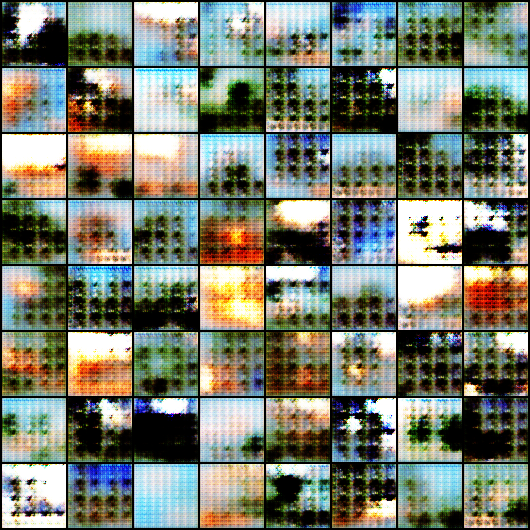

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0013.png')

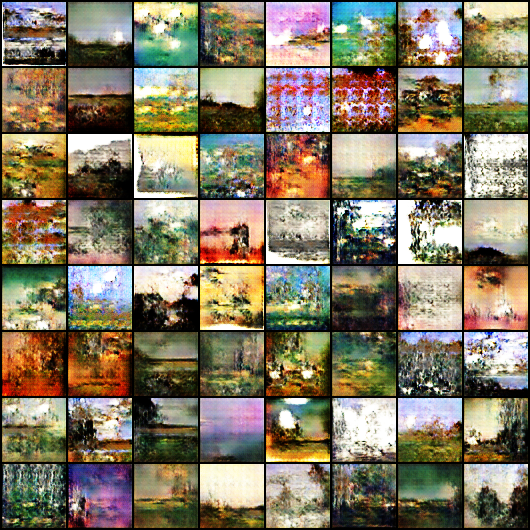

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0037.png')

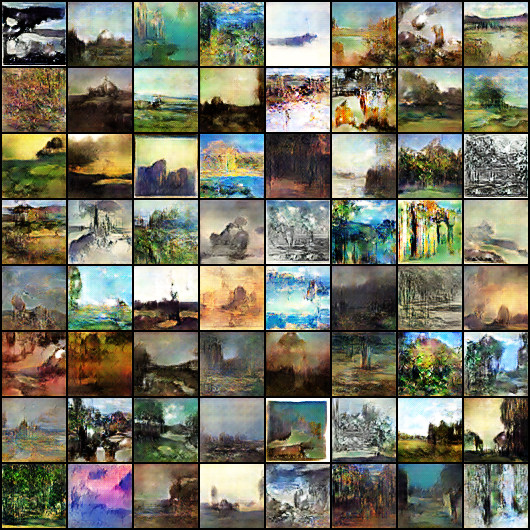

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0072.png')

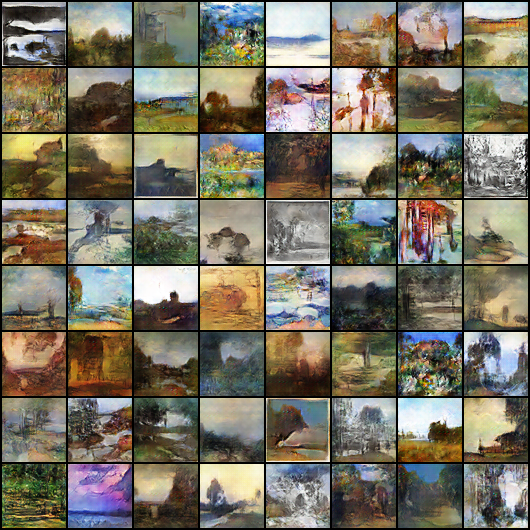

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0103.png')

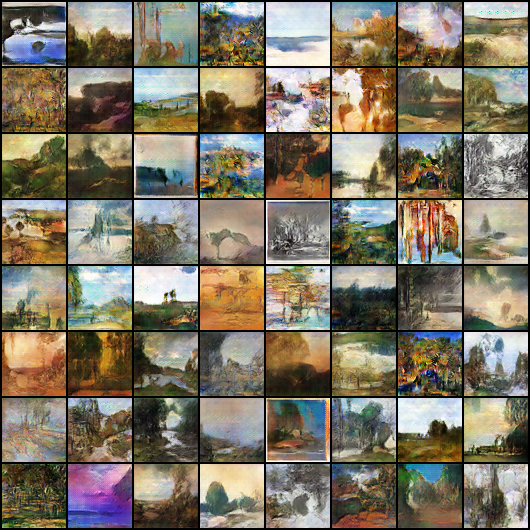

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0138.png')

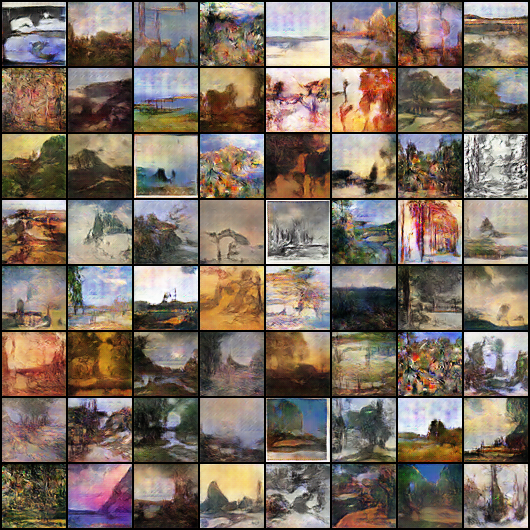

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0147.png')

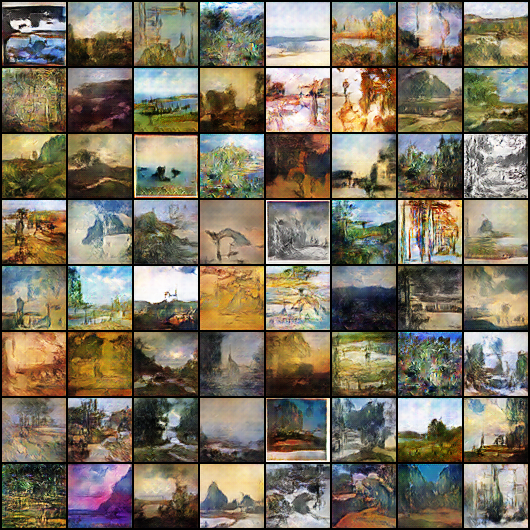

In [ ]:
Image('drive/MyDrive/generatedLandscape/generated-images-0150.png')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'drive/MyDrive/models/G.ckpt')
torch.save(discriminator.state_dict(), 'drive/MyDrive/models/D.ckpt')

**Plotting metrics**

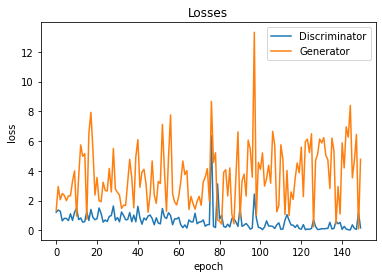

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

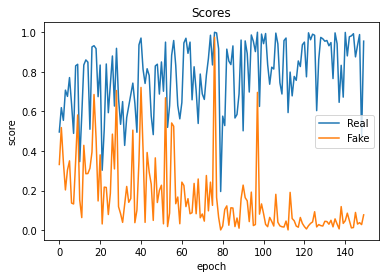

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Creating a gif to show models improvement over epochs

In [ ]:
import cv2
import os

vid_fname = 'drive/MyDrive/generatedLandscape/gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()